# Heterogeneous Data
Heterogeneous data is data that is made up of many different types and scales, if left raw a model will be unable to effectively use this data.  The raw data provided will need to be processed before it can be used to train a model, in fact i've read estimates that half of the machine learning workflow is just preparing and manipulating data before training takes place.  Many concepts in machine learning are intertwined so it is difficult to talk about a single topic, due to this there are some things that we discuss today that you will need to just keep in mind until we get to them later.

## Curse of Dimensionality
Last time we talked about how these machines thrived on data, this is true though not specific enough.  Samples are almost always going to be good, features however can be terrible or awesome depending on the situation.  The reason for this is called the curse of dimensionality, essentially the more complex a problem is, the more samples you will need to uncover the shape of the function.  Each feature adds complexity, a feature removed adds simplicity.  Imagine a simple 1D example, we would not need many samples to uncover what value a function is returning.  If we add a dimension now we're trying to figure out the 2D line hidden in the data, this would take more samples to uncover.  Adding yet another dimension to 3D would require even more samples.  Now imagine having 100s of features.

<img src="images\curse_of_d.png" width=800/>

Later on we'll discuss how we detect if we are too complex or too simple, for now lets discuss some different ways to fix this problem.  We've already talked about this actually, checking input feature collinearity to remove redundant features, or using the correlation matrix to move irrelevant inputs.

## Feature Selection
Feature selection is a technique that reduces the dimensionality by eliminating features that don't score as well as others.  There is a lot of math behind how this is calculated, but it is related to how correlated they are.  Lets look at the iris data set, maybe we detect that four features is too many and we need to reduce this.  One of our first steps should be to check out a correlation plot, clearly we can see that feature '1' isn't as correlated to the output feature '4'.  Before we remove this feature we need more information.

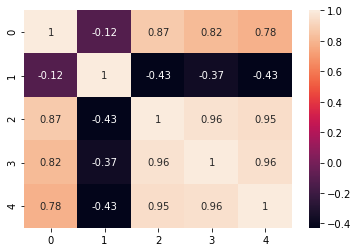

In [16]:
from sklearn.datasets import load_iris
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

data = load_iris()
X = data.data
y = data.target

# weird numpy flex, easier to do this through a df
mat = np.corrcoef(np.hstack([X, y.reshape((150, 1))]), rowvar=False)
sns.heatmap(mat, annot=True)
plt.show()

The SelectKBest tool will automatically remove k number of the worst scoring features, however the best thing about this tool is the ability to see how the features scored.  I will typically use these scores along with the correlation plot, collinearity plot (and many other things) to make a choice on what features to keep.  First create a selectkbest object and tell it how many features you would like to keep (or 'all' to keep everything and just evaluate scores), you also need to specify if the output is quantitative or categorical by setting the score function. Once created you call fit for the estimator to learn the feature scores, you can call fit\_transform to have it return the k number of best features.

In [17]:
from sklearn.feature_selection import SelectKBest, f_regression, f_classif

kselect = SelectKBest(k='all', score_func=f_classif)
kselect.fit(X, y)

print(kselect.scores_)

[ 119.26450218   49.16004009 1180.16118225  960.0071468 ]


Lets graph the results and see how well the selected features correspond to the output.  Not bad!  The colors (labels) are linearly separable, meaning we can mostly draw a line between them which should make it easier to identify each group.  Try the commented out code below and see how well the other two features correspond.

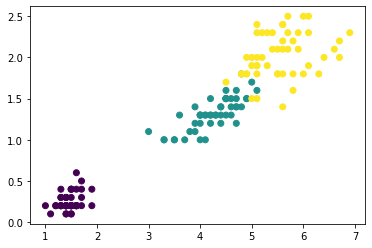

In [18]:

kselect = SelectKBest(k=2, score_func=f_classif)
X_best = kselect.fit_transform(X, y)

plt.scatter(X_best[:,0], X_best[:,1], c=y)
# plt.scatter(X[:,0], X[:,1], c=y)
plt.show()

So feature selection is a great tool for identifying poor performing features, but what would happen if all of the features scored roughly the same?  In this case we would still need to remove k features though there would still be good data there.  In these cases another approach (or combination of approaches) might be appropriate.

Another trick I like to do is graph the scores to help understand the difference in scores.

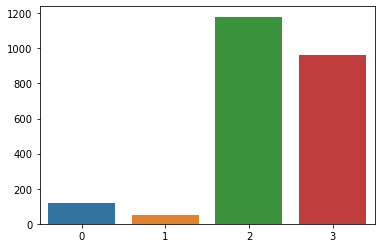

In [19]:
# here you could put the column names in for X to make it more readable
sns.barplot(x=[i for i in range(len(kselect.scores_))], y=kselect.scores_)
plt.show()

## PCA
Principal component analysis is an algorithm that reduces the input data to a lower dimensional space, this is done by combining features instead of removing them.  Points of maximum variance with minimum error are found, basically a vector is drawn through the data that becomes the new axis, then samples are moved to this new axis.  If features in a dataset are very similar they are more easily combined, also the number of dimensions you are reducing down to can affect performance.   Explained variance ratio tells us how much of the original data we retained (when we move the points to the new axis that information is lost), we can also undo the effects of pca with the inverse_transform function.

Compare the output of this operation to the input, the values are wildly different!  ML models don't care what the meaning of the data fed to them, only that they can make a change in the inputs to a change in the outputs.

In [20]:
from sklearn.decomposition import PCA
import numpy as np

X = np.array([[20, 0], [10, 5], [40, 30], [70, 60], [75, 80], [80, 80]])

pca = PCA(n_components=1)
X = pca.fit_transform(X)

print(X)
print(f'variance explained: {pca.explained_variance_ratio_}')

[[ 51.32552815]
 [ 53.87697723]
 [ 15.47193685]
 [-26.77694017]
 [-45.3499296 ]
 [-48.54757246]]
variance explained: [0.99078638]


We do have to be careful with PCA as it can damage a model, for example what if the maximum variance is horizontal but labels are separated vertically?  One way to visualize this operation is a book closing, lets take a look at an example going all the way from 3d to 1d.  3D to 2D is difficult to visualize, though if we look at 2D to 1D we should be able to see whats happening.  The range of values on the x axis (6) is greater than that of the y axis (2.5), so PCA would draw a new axis (roughly) at 0 on the y and then translate all points down to this new axis.  Pick a point on the 2D graph and see if you can find it on the new axis.

[0.5230551  0.27737915]
[0.65346417]


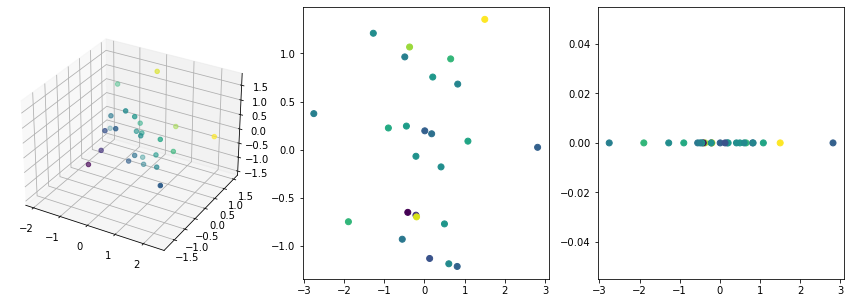

In [21]:
from sklearn.datasets import make_regression
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

X, y = make_regression(n_samples=25, n_features=3, noise=0, random_state=10)

fig = plt.figure(figsize=(15,5))

ax1 = fig.add_subplot(131, projection='3d')
ax1.scatter(X[:,0], X[:,1], X[:,2], c=y)

pca = PCA(n_components=2)
X = pca.fit_transform(X)
print(pca.explained_variance_ratio_)
ax2 = fig.add_subplot(132)
ax2.scatter(X[:,0], X[:,1], c=y)

pca = PCA(n_components=1)
X = pca.fit_transform(X)
print(pca.explained_variance_ratio_)
ax3 = fig.add_subplot(133)
ax3.scatter(X[:,0], [0 for i in range(len(X))], c=y)
plt.show()

Lets revisit the iris data set and see how pca would transform the input features, the graph should look similar to the version where we used feature selection.  This data used to represent measurements of flower petals, yet these data points are negative, remember pca transforms your data which removes units and any symbolic meaning.  Also notice in this example we have two elements in explained variance since we reduced down to two dimensions.  The sum of all variance should be less than (possibly equal to) 1.

[0.92461872 0.05306648]


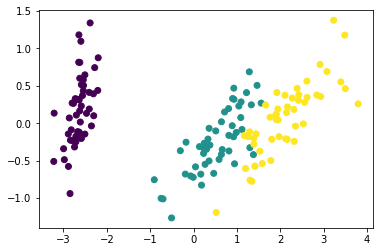

In [22]:
data = load_iris()
X = data.data
y = data.target

pca = PCA(n_components=2)
y_pca = pca.fit_transform(X)
print(pca.explained_variance_ratio_)

plt.scatter(y_pca[:,0], y_pca[:,1], c=y)
plt.show()

We can visualize the variance loss of pca, this is a useful technique since it can be difficult to guess how much to reduce your data set by with a large number of inputs.

[0.92461872 0.97768521 0.99478782 1.        ]


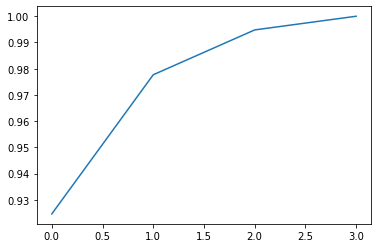

In [23]:
pca = PCA(n_components=4)
pca.fit_transform(X)
print(pca.explained_variance_ratio_.cumsum())

plt.plot(pca.explained_variance_ratio_.cumsum())
plt.show()

### Decorrelation
One inherent ability of PCA is the ability to de-correlate your inputs, even if you don't remove any dimensionality you can tune pca with the 'whiten' flag to not reduce dimensionality.

# OK
We now have some more tools to help us reduce complexity of a problem, remember is is very unlikely you would use a single tool, it is typically a combination of techniques that will give us the best results.  So if it is determined that our problem is too complex we will use the correlation plot, collinearity plot, selectkbest scores, and PCA to try and reduce the difficulty of the problem.  Eventually we are going to go the other way to and make the problem more complex.